In [3]:
import matplotlib.pyplot as plt
import numpy as np
import wisc_ecephys_tools as wet
import xarray as xr
from ecephys import xrsig

from findlay2025a import core, dentate_spikes
from findlay2025a.constants import Experiments as Exps

In [ ]:
sglx_subject = wet.get_sglx_subject("CNPIX4-Doppio")
experiment = Exps.NOD
s3 = core.get_project("shared")
nb = core.get_project("seahorse")

hg = s3.load_float_hypnogram(experiment, sglx_subject.name, simplify=True)
lfp = core.open_hippocampal_lfps(sglx_subject.name, experiment)
kcsd = (
    core.open_kcsd(sglx_subject.name, experiment)
    .assign_attrs(fs=lfp.fs)
    .assign_coords(acronym=lfp.acronym)
)
dspks = dentate_spikes.read_dspks(sglx_subject.name, experiment)

/home/gfindlay/projects/ece/ecephys/ecephys/wne/utils.py:167: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 128069. This could degrade performance. Instead, consider rechunking after loading.
  lf = xr.open_dataarray(lf_file, engine="zarr", chunks=chunks, **xr_kwargs)
/home/gfindlay/projects/ece/ecephys/ecephys/wne/utils.py:167: UserWarning: The specified chunks separate the stored chunks along dimension "channel" starting at index 262. This could degrade performance. Instead, consider rechunking after loading.
  lf = xr.open_dataarray(lf_file, engine="zarr", chunks=chunks, **xr_kwargs)


In [6]:
use_estm = True
if use_estm:
    t1, t2 = core.get_estimation_bounds(sglx_subject, experiment)
else:
    t1 = t2 = None
lfp = lfp.sel(time=slice(t1, t2)).load()
kcsd = kcsd.sel(time=slice(t1, t2)).load()

In [7]:
dspk_lfps, in_lfps = xrsig.make_trialed(
    lfp, pre=0.5, post=0.5, event_times=dspks.peak_time.values
)
if not in_lfps.all():
    print("Warning: Not all events are in bounds")
dspk_lfps = xrsig.detrend_trialed(dspk_lfps)
dspk_erps = dspk_lfps.mean(dim="event").assign_attrs(fs=lfp.fs)

dspk_csds, in_csds = xrsig.make_trialed(
    kcsd, pre=0.5, post=0.5, event_times=dspks.peak_time.values
)
if not in_csds.all():
    print("Warning: Not all events are in bounds")
dspk_ercs = dspk_csds.mean(dim="event").assign_attrs(fs=kcsd.fs)

Fitting detrend polynomial...
Evaluating detrend polynomial...
Subtracting detrend polynomial...


Text(0.5, 0, '')

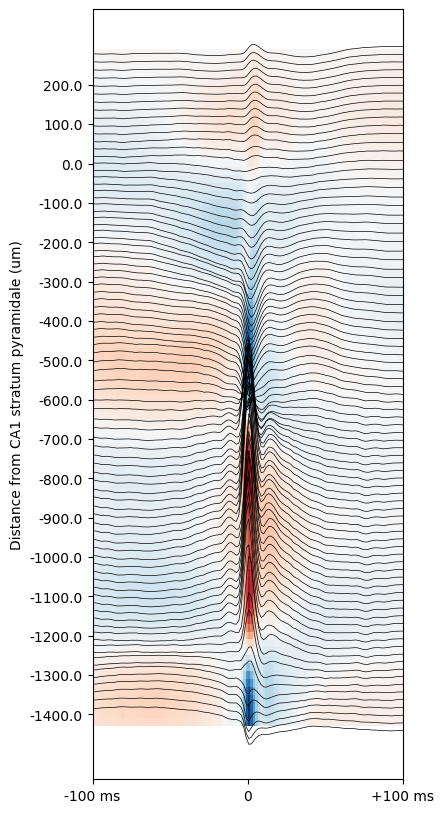

In [ ]:
fig, axes = plt.subplots(figsize=(4, 10))
xrsig.plot_laminar_image_vertical(
    dspk_ercs.isel(channel=slice(20, -5)), x="time", ax=axes, add_colorbar=False
)
xrsig.plot_laminar_timeseries(dspk_erps.isel(channel=slice(20, -5)), gain=0.25, ax=axes)
y = dspk_erps.isel(channel=slice(20, -5)).y.values - 5520.0
axes.set_yticklabels(y, fontsize=10)
axes.set_yticks(axes.get_yticks()[1::5])
axes.set_ylabel("Distance from CA1 stratum pyramidale (um)")
axes.set_xlim(-0.1, 0.1)
axes.set_xticks([-0.1, 0, 0.1])
axes.set_xticklabels(["-100 ms", "0", "+100 ms"], fontsize=10)
axes.set_xlabel(None)

# fig.savefig(nb.get_project_file('figures/avg_dspk.svg'), bbox_inches='tight')
# fig.savefig(nb.get_project_file('figures/avg_dspk.png'), dpi=600, bbox_inches='tight')

In [9]:
ca1p_lfps = dspk_lfps.sel(channel=(dspk_lfps.y == 5520))
ca1p_cwts = xr.concat(
    [
        xrsig.cwt(ca1p_lfps.sel(event=evt)).assign_coords(event=evt)
        for evt in ca1p_lfps.event.values
    ],
    dim="event",
).squeeze()
ca1p_avg_cwt = (np.abs(ca1p_cwts) ** 2).mean(dim="event")

In [10]:
ca3_lfps = dspk_lfps.sel(channel=(dspk_lfps.y == 4600))
ca3_cwts = xr.concat(
    [
        xrsig.cwt(ca3_lfps.sel(event=evt)).assign_coords(event=evt)
        for evt in ca3_lfps.event.values
    ],
    dim="event",
).squeeze()
ca3_avg_cwt = (np.abs(ca3_cwts) ** 2).mean(dim="event")

[Text(-0.1, 0, '-100 ms'), Text(0.0, 0, '0'), Text(0.1, 0, '+100 ms')]

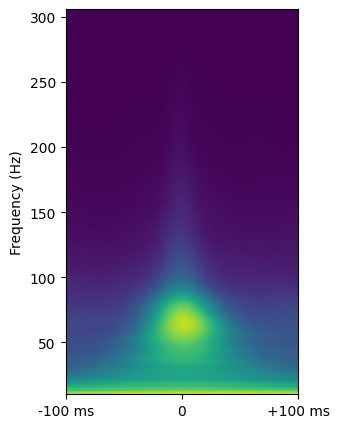

In [ ]:
fig, ax = plt.subplots(figsize=(3, 5))
da_ = ca3_avg_cwt.sel(frequency=slice(10, 310))
ax.pcolormesh(da_.time.values, da_.frequency.values, da_.values, shading="gouraud")
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel(None)
ax.set_xlim(-0.1, 0.1)
ax.set_xticks([-0.1, 0, 0.1])
ax.set_xticklabels(["-100 ms", "0", "+100 ms"])